In [1]:
import os
import argparse
from utils import bool_ext, load_dataset, split_dataset, evaluate, checkCorrelations
from models import CITRUS
import pickle
import torch
import numpy as np
import pandas as pd
import warnings 
warnings.filterwarnings("ignore") ##This is bad but temporary

device = 'cuda' if torch.cuda.is_available() else 'cpu'

if device == 'cuda':
    device_name = torch.cuda.get_device_name(0)
else:
    device_name = 'cpu'


parser = argparse.ArgumentParser()

parser.add_argument(
    "--input_dir", 
    help="directory of input files", 
    type=str, 
    default="./data"
)
parser.add_argument(
    "--output_dir",
    help="directory of output files",
    type=str,
    default="./output",
)
parser.add_argument(
    "--embedding_size",
    help="embedding dimension of genes and tumors",
    type=int,
    default=512,
)
parser.add_argument(
    "--hidden_size", 
    help="hidden layer dimension of MLP decoder", 
    type=int, 
    default=400
)
parser.add_argument(
    "--attention_size", 
    help="size of attention parameter beta_j", 
    type=int, 
    default=256
)
parser.add_argument(
    "--attention_head", 
    help="number of attention heads", 
    type=int, 
    default=8
)
parser.add_argument(
    "--learning_rate", 
    help="learning rate for Adam", 
    type=float, 
    default=1e-3
)
parser.add_argument(
    "--max_iter", 
    help="maximum number of training iterations", 
    type=int, 
    default=1000
)
parser.add_argument(
    "--max_fscore",
    help="Max F1 score to early stop model from training",
    type=float,
    default=0.7
)
parser.add_argument(
    "--batch_size", 
    help="training batch size", 
    type=int, 
    default=100
)
parser.add_argument(
    "--test_batch_size", 
    help="test batch size", 
    type=int, 
    default=100
)
parser.add_argument(
    "--test_inc_size",
    help="increment interval size between log outputs",
    type=int,
    default=256
)
parser.add_argument(
    "--dropout_rate", 
    help="dropout rate", 
    type=float, 
    default=0.2
)
parser.add_argument(
    "--input_dropout_rate", 
    help="dropout rate", 
    type=float, 
    default=0.2
)
parser.add_argument(
    "--weight_decay", 
    help="coefficient of l2 regularizer", 
    type=float, 
    default=1e-5
)
parser.add_argument(
    "--activation",
    help="activation function used in hidden layer",
    type=str,
    default="tanh",
)
parser.add_argument(
    "--patience", 
    help="earlystopping patience", 
    type=int, 
    default=30
)
parser.add_argument(
    "--mask01",
    help="wether to ignore the float value and convert mask to 01",
    type=bool_ext,
    default=True,
)
parser.add_argument(
    "--gep_normalization", 
    help="how to normalize gep", 
    type=str, 
    default="scaleRow"
)
parser.add_argument(
    "--attention",
    help="whether to use attention mechanism or not",
    type=bool_ext,
    default=True,
)
parser.add_argument(
    "--cancer_type",
    help="whether to use cancer type or not",
    type=bool_ext,
    default=True,
)
parser.add_argument(
    "--train_model",
    help="whether to train model or load model",
    type=bool_ext,
    default=True,
)
parser.add_argument(
    "--dataset_name",
    help="the dataset name loaded and saved",
    type=str,
    default="dataset_CITRUS",
)
parser.add_argument(
    "--tag", 
    help="a tag passed from command line", 
    type=str, 
    default=""
)
parser.add_argument(
    "--run_count", 
    help="the count for training", 
    type=str, 
    default="1"
)


args = parser.parse_args([])

if not os.path.exists(args.output_dir):
    os.makedirs(args.output_dir)

print("Loading dataset...")
dataset, dataset_test = load_dataset(
    input_dir=args.input_dir,
    mask01=args.mask01,
    dataset_name=args.dataset_name,
    gep_normalization=args.gep_normalization,
)

train_set, test_set = split_dataset(dataset, ratio=0.66)

args.can_size = dataset["can"].max()  # cancer type dimension
args.sga_size = dataset["sga"].max()  # SGA dimension
args.gep_size = dataset["gep"].shape[1]  # GEP output dimension
args.num_max_sga = dataset["sga"].shape[1]  # maximum number of SGAs in a tumor

args.hidden_size = dataset["tf_gene"].shape[0]
print("Hyperparameters:")
print(args)
args.tf_gene = dataset["tf_gene"]


model = CITRUS(args)  # initialize CITRUS model
model.build(device=device)  # build CITRUS model
model.to(device);

Loading dataset...
Hyperparameters:
Namespace(activation='tanh', attention=True, attention_head=8, attention_size=256, batch_size=100, can_size=17, cancer_type=True, dataset_name='dataset_CITRUS', dropout_rate=0.2, embedding_size=512, gep_normalization='scaleRow', gep_size=5541, hidden_size=320, input_dir='./data', input_dropout_rate=0.2, learning_rate=0.001, mask01=True, max_fscore=0.7, max_iter=1000, num_max_sga=1396, output_dir='./output', patience=30, run_count='1', sga_size=11998, tag='', test_batch_size=100, test_inc_size=256, train_model=True, weight_decay=1e-05)


In [2]:
model = CITRUS(args)  # initialize CITRUS model
model.build(device=device)  # build CITRUS model
model.to(device)

model.load_state_dict(torch.load(f'/ihome/hosmanbeyoglu/kor11/tools/CITRUS/output/model0909.pth', 
                    map_location=torch.device('cpu')))
model.eval()

CITRUS(
  (layer_sga_emb): Embedding(11999, 512, padding_idx=0)
  (layer_can_emb): Embedding(18, 512, padding_idx=0)
  (layer_w_0): Linear(in_features=512, out_features=256, bias=True)
  (layer_beta): Linear(in_features=256, out_features=8, bias=True)
  (layer_dropout_1): Dropout(p=0.2, inplace=False)
  (layer_dropout_2): Dropout(p=0.2, inplace=False)
  (layer_w_1): Linear(in_features=512, out_features=6, bias=True)
  (bnorm_pathways): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_pathways): Linear(in_features=6, out_features=44, bias=True)
  (middle_pathways): Linear(in_features=44, out_features=330, bias=True)
  (local_pathways): Linear(in_features=330, out_features=320, bias=True)
  (bnorm_tf): BatchNorm1d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer_w_2): Linear(in_features=320, out_features=5541, bias=True)
  (loss): MSELoss()
)

In [3]:
from utils import Data

data = Data(
    fGEP_SGA = 'data/CITRUS_GEP_SGAseparated.csv',
    fgene_tf_SGA = 'data/CITRUS_gene_tf_SGAseparated.csv',
    fcancerType_SGA = 'data/CITRUS_canType_SGAseparated.csv',
    fSGA_SGA = 'data/CITRUS_SGA_SGAseparated.csv',
)

d = data.cancerType_sga.loc[dataset['tmr']]
d['index'] = dataset['can'].reshape(-1)

xdf = pd.DataFrame(enumerate(dataset['tmr']))
xdf.columns = ['idx', 'id']

brca = pd.DataFrame(data.sga_sga.loc[data.cancerType_sga[data.cancerType_sga['type']=='BRCA'].index])

wt = brca[(brca['SM_PIK3CA'] == 0) & (brca['SCNA_PIK3CA'] == 0)]
sm_mut = brca[(brca['SM_PIK3CA'] == 1) & (brca['SCNA_PIK3CA'] == 0)]
scna_mut = brca[(brca['SM_PIK3CA'] == 0) & (brca['SCNA_PIK3CA'] == 1)]
sm_scna_mut = brca[(brca['SM_PIK3CA'] == 1) & (brca['SCNA_PIK3CA'] == 1)]
wt.shape, sm_mut.shape, scna_mut.shape, sm_scna_mut.shape

((435, 11998), (253, 11998), (20, 11998), (12, 11998))

In [4]:
from captum.attr import LayerConductance, LayerActivation, LayerIntegratedGradients
from captum.attr import IntegratedGradients
from scipy.stats import ttest_ind

In [9]:
import requests
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm

def get_name(pathway):
    url = 'https://reactome.org/content/detail/' + pathway
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    try:
        return soup.find_all('h3')[0].text.strip()
    except:
        return None

In [14]:
pathway_names = dict(zip(np.load('pathway_names_keys.npy', allow_pickle=True), 
    np.load('pathway_names_values.npy', allow_pickle=True)))
pathway_names_inverse = dict(zip(np.load('pathway_names_values.npy', allow_pickle=True), 
                        np.load('pathway_names_keys.npy', allow_pickle=True)))
_pathways = np.load('_pathways.npy', allow_pickle=True)

In [24]:
path_tf_mask = np.load('pathway_tf_mask2.npy', allow_pickle=True)


In [36]:
pd.DataFrame(path_tf_mask, index=data.gene_tf_sga.columns, columns=_pathways[2])[['PI3K/AKT Signaling in Cancer']].sort_values(by='PI3K/AKT Signaling in Cancer', ascending=False)[:6]

,PI3K/AKT Signaling in Cancer
FOXO3,1
ESR1,1
NR4A1,1
FOXO1,1
ESR2,1
CREB1,1


In [15]:
reactome = np.load('./pnet_prostate_paper/train/reactome_layers.npy', allow_pickle=True)[::-1]

In [6]:
from tqdm.notebook import tqdm

In [47]:
M = model
M.analysis_mode = True
lc = LayerConductance(M, M.local_pathways)

results = []
AA = []

for frame, name in zip([wt, sm_mut, scna_mut, sm_scna_mut], ['WT', 'SM', 'SCNA', 'SM_SCNA']):
    
    scores = []

    idx = xdf[xdf.id.isin(frame.index)].idx.values
    X = torch.from_numpy(dataset['sga'])

    # G = [i for i in data.gene_tf_sga.index if 'AKT' in i] + [i for i in data.gene_tf_sga.index if 'PIK' in i]
    # G = ['PIK3CA']
    # G = [i for i in data.gene_tf_sga.index if 'AKT' in i]
    # G = [i for i in data.gene_tf_sga.index if 'PIK' in i]
    
    # G = ['AKT1', 'PIK3CA', 'AKT2']
    
    
    G = ['AKT1']

    for ix in tqdm([list(data.gep_sga.columns).index(g) for g in G if g in data.gep_sga.columns]):
        a = lc.attribute((X[idx], torch.from_numpy(dataset['can'][idx])), n_steps=5, 
                        attribute_to_layer_input=True, target=[ix]*len(X[idx]))
        ig_attr_test_sum = a.detach().cpu().numpy().sum(0)
        ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)
        scores.append(ig_attr_test_norm_sum)
        
    AA.append(a)
    g = np.array(M.local2tf.index)
    at = np.sum(scores, 0)
    
    assert g.shape == at.shape

    df = pd.DataFrame([g, at]).T
    df.columns = ['Pathways', f'score_{name}']
    results.append(df.set_index('Pathways'))
    
AA = np.array([i.detach().numpy() for i in AA])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [49]:
df = results[0]

In [50]:
abs(df['score_WT']).sort_values(ascending=False).replace(0, np.nan).dropna()[:10]

Pathways
Autophagy - other                    0.100340
Platinum drug resistance             0.091230
PI3K-Akt signaling pathway           0.081111
Sulfur metabolism                    0.061132
RNA transport                        0.059007
B cell receptor signaling pathway    0.053193
ErbB signaling pathway               0.042611
Estrogen signaling pathway           0.042336
Aminoacyl-tRNA biosynthesis          0.040801
Bile secretion                       0.040441
Name: score_WT, dtype: float64

In [51]:
meanChange = pd.concat(results, axis=1)['score_SM'] - pd.concat(results, axis=1)['score_WT'].values
pvals = [ttest_ind(AA[0][:, i], AA[1][:, i]).pvalue for i in range(330)]
volcano = pd.DataFrame([meanChange.values, pvals], columns=M.local2tf.index).T.dropna()
volcano.columns = ['meanChange', 'pvalue']
volcano[volcano.pvalue < 0.05].sort_values(by='pvalue')

,meanChange,pvalue
Cocaine addiction,-6.962761e-03,0.021531
Cushing syndrome,-1.427714e-03,0.021532
Viral carcinogenesis,3.454294e-03,0.022547
Rheumatoid arthritis,1.365389e-03,0.022672
Gastric cancer,-2.056994e-03,0.022913
Sulfur metabolism,1.218959e-02,0.023164
Human cytomegalovirus infection,-1.821551e-03,0.026381
Drug metabolism - cytochrome P450,-9.410251e-14,0.026865
Glycosaminoglycan degradation,-1.303154e-14,0.027134
Vitamin B6 metabolism,-1.506256e-04,0.027726


In [53]:
M.local2tf.sum(1).loc[volcano[volcano.pvalue < 0.05].sort_values(by='pvalue').index]

Cocaine addiction                                          9
Cushing syndrome                                          12
Viral carcinogenesis                                      10
Rheumatoid arthritis                                      16
Gastric cancer                                             7
Sulfur metabolism                                         13
Human cytomegalovirus infection                           16
Drug metabolism - cytochrome P450                          4
Glycosaminoglycan degradation                              4
Vitamin B6 metabolism                                      9
Longevity regulating pathway - multiple species            3
PI3K-Akt signaling pathway                                10
Progesterone-mediated oocyte maturation                   43
Prolactin signaling pathway                                8
Glycosylphosphatidylinositol (GPI)-anchor biosynthesis     9
Neomycin, kanamycin and gentamicin biosynthesis            5
Caffeine metabolism     

In [21]:
np.load('pathway_tf_mask2.npy', allow_pickle=True).shape

(320, 447)

In [22]:
# freq = pd.DataFrame([len(merged.get(pathway_names_inverse[i], [])) for i in pathway_tf_mask.columns], index=_pathways[2])
# freq.columns = ['count']
# freq['scores'] = at
# freq['TFs'] = pathway_tf_mask.sum(0).sort_values(ascending=False).values
# freq.sort_values(by='scores', ascending=False)[:20]

In [ ]:
pd.DataFrame(np.where(data.gene_tf_sga.values > 0, 1, 0), 
    index=data.gene_tf_sga.index, 
    columns=data.gene_tf_sga.columns).sum(0).sort_values(ascending=False)[:10].index

SP4       2924
ZFX       2868
PLAG1     2808
RARB      2656
FOXO1     2528
CTCF      2466
TCF12     2454
ZNF219    2447
IRF1      2418
FOXJ3     2385
dtype: int64

In [23]:
scores = []
idx = xdf[xdf.id.isin(brca.index)].idx.values
X = torch.from_numpy(dataset['sga'])
# G = [i for i in data.gene_tf_sga.index if 'AKT' in i]
# G = [i for i in data.gene_tf_sga.index if 'PIK' in i]

# G = [i for i in data.gene_tf_sga.index if 'AKT' in i] + [i for i in data.gene_tf_sga.index if 'PIK' in i]

# G = pd.DataFrame(np.where(data.gene_tf_sga.values > 0, 1, 0), 
#     index=data.gene_tf_sga.index, 
#     columns=data.gene_tf_sga.columns).sum(0).sort_values(ascending=False)[:50].index

G = ['AKT1']

for ix in tqdm([list(data.gep_sga.columns).index(g) for g in G if g in data.gep_sga.columns]):
    a = lc.attribute((X[idx], torch.from_numpy(dataset['can'][idx])), n_steps=5, 
                    attribute_to_layer_input=True, target=[ix]*len(X[idx]))
    ig_attr_test_sum = a.detach().cpu().numpy().sum(0)
    ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)
    scores.append(ig_attr_test_norm_sum)
    
g = np.array(masks[2].columns)
at = np.sum(scores, 0)

assert g.shape == at.shape

df = pd.DataFrame([g, at]).T
df.columns = ['Pathways', f'score']
df['Pathways'] = df['Pathways'].apply(lambda x: pathway_names[x])

abs(df.set_index('Pathways').sort_values(by='score', ascending=False))[:20]

  0%|          | 0/1 [00:00<?, ?it/s]

,score
Pathways,
Signaling by NOTCH4,0.21077
Signaling by NOTCH1,0.177736
Signaling by NOTCH3,0.163005
Mitotic G1 phase and G1/S transition,0.102892
Mitotic G2-G2/M phases,0.100993
Signaling by NOTCH1 in Cancer,0.089228
Cellular Senescence,0.041914
Activation of anterior HOX genes in hindbrain development during early embryogenesis,0.035628
Pre-NOTCH Expression and Processing,0.027069


In [ ]:
np.load('')

In [85]:
from locale import normalize


abs(pd.DataFrame(scores, index=[g for g in G if g in data.gep_sga.columns], 
    columns = df['Pathways'])[['PI3K/AKT Signaling in Cancer', 'PIP3 activates AKT signaling']]).sum(1).sort_values(ascending=False)[:20].index

Index(['SPIB', 'FOSL1', 'BCL11A', 'E2F1', 'ELF3', 'TBX2', 'ESR1', 'EGR2',
       'THRA', 'RARB', 'IRF8', 'IRF1', 'IRF3', 'RUNX2', 'THRB', 'ZNF350',
       'EBF1', 'NR5A2', 'CTCFL', 'FOXO1'],
      dtype='object')

In [86]:
G

Index(['SP4', 'ZFX', 'PLAG1', 'RARB', 'FOXO1', 'CTCF', 'TCF12', 'ZNF219',
       'IRF1', 'FOXJ3', 'FOXJ2', 'TFAP2A', 'E2F6', 'E2F1', 'FOXP1', 'CTCFL',
       'THRB', 'SPI1', 'IRF5', 'SMAD1', 'BCL11A', 'EGR2', 'RARG', 'EBF1',
       'FUBP1', 'ZEB1', 'FOXA3', 'ESR1', 'THRA', 'NR2C2', 'TBX2', 'SMARCC1',
       'ARID3A', 'IRF8', 'TP63', 'ELF2', 'IRF3', 'TFAP4', 'ELF1', 'TFCP2',
       'FLI1', 'KLF3', 'RUNX2', 'TP73', 'ZNF350', 'SPIB', 'ELF3', 'NR5A2',
       'ID4', 'FOSL1'],
      dtype='object')

In [22]:
hue = []
for r in volcano.iterrows():
    label = r[0]
    change = r[1].meanChange
    pvalue = r[1].pvalue
    
    c = 'NA'
    if pvalue < 0.05:
        c = 'NA'
        if change < 0.1:
            c = 'DOWN'
        if change > 0.1:
            c = 'UP' 
            
    hue.append(c)

In [23]:
volcano['hue'] = hue

In [24]:
volcano[volcano['hue']!='NA']

,meanChange,pvalue,hue
Pathways,,,
Synaptic adhesion-like molecules,0.000329,0.011311,DOWN
Negative epigenetic regulation of rRNA expression,0.000022,0.041927,DOWN
M Phase,0.000719,0.034347,DOWN
Nonhomologous End-Joining (NHEJ),0.000019,0.003699,DOWN
Signaling by ERBB2,0.000134,0.013861,DOWN
GP1b-IX-V activation signalling,0.000158,0.009623,DOWN
Nitric oxide stimulates guanylate cyclase,0.001241,0.001929,DOWN
Neutrophil degranulation,-0.000656,0.001578,DOWN
Signaling by Type 1 Insulin-like Growth Factor 1 Receptor (IGF1R),0.000507,0.037442,DOWN


In [158]:
import seaborn as sns
import matplotlib.pyplot as plt

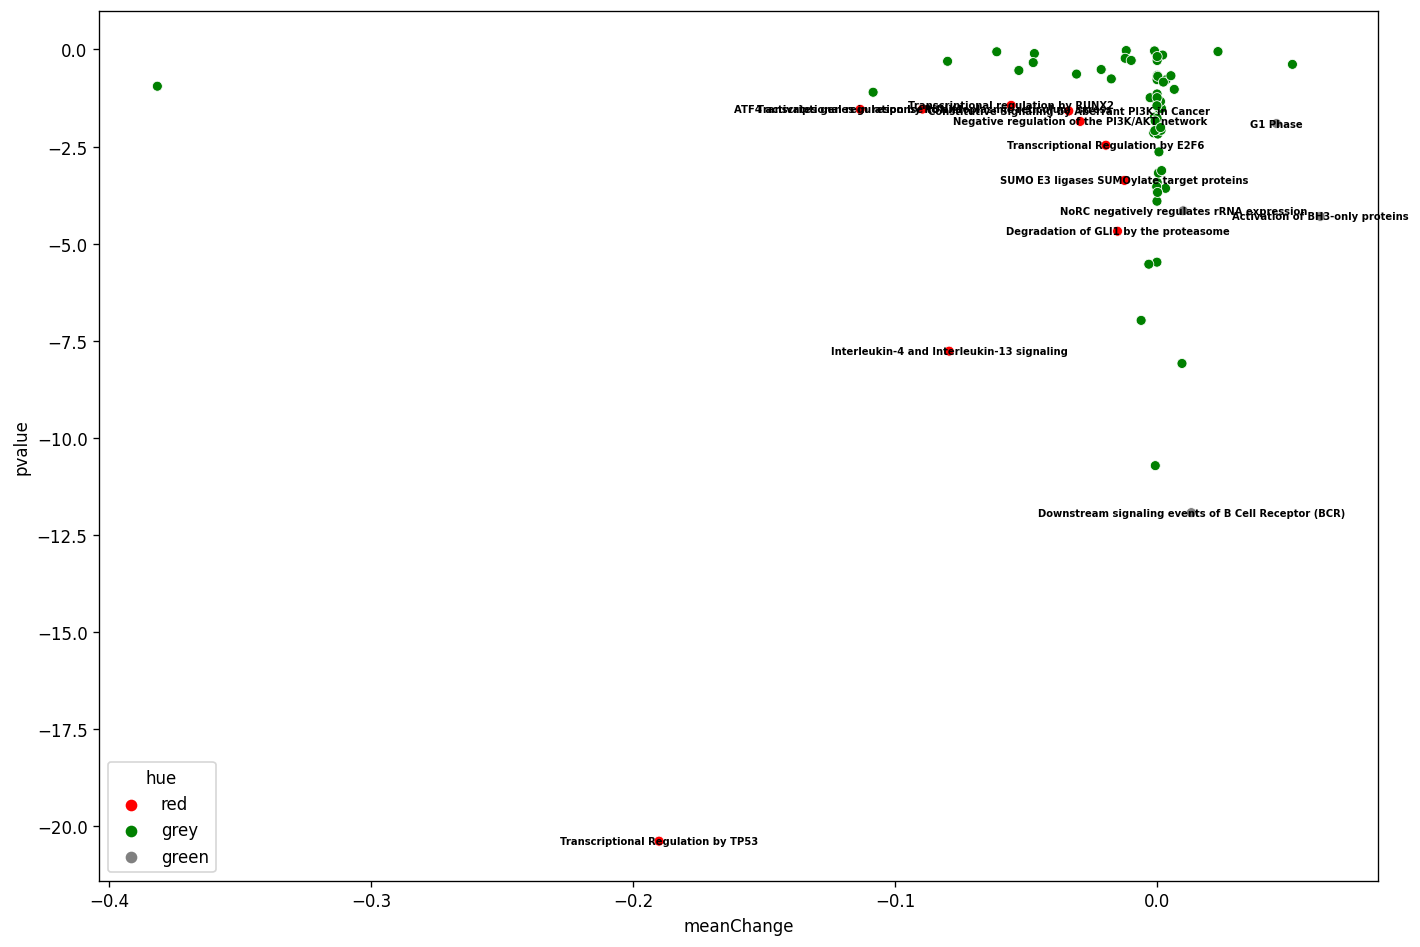

In [183]:
plt.figure(figsize=(12, 8), dpi=120)
sns.scatterplot(data=volcano, x='meanChange', y='pvalue', hue='hue', palette=('red', 'green', 'grey'))

for r in volcano.iterrows():
    label = r[0]
    change = r[1].meanChange
    pvalue = r[1].pvalue
    if r[1].hue != 'grey':
        plt.annotate(label, 
                (change, pvalue),
                horizontalalignment='center',
                verticalalignment='center',
                size=6, weight='bold')

plt.tight_layout()
# plt.savefig('pathways_volcano.png', dpi=180)
plt.show()

In [66]:
mm = masks[0]
mm.columns = _pathways

In [91]:
df

,Pathways,score
0,POLB-Dependent Long Patch Base Excision Repair,0.0
1,PCNA-Dependent Long Patch Base Excision Repair,0.0
2,Abasic sugar-phosphate removal via the single-...,0.0
3,Cytochrome c-mediated apoptotic response,0.0
4,Caspase-mediated cleavage of cytoskeletal prot...,0.0
...,...,...
1382,"Antigen Presentation: Folding, assembly and pe...",0.0
1383,Kinesins,0.0
1384,CD22 mediated BCR regulation,0.0
1385,Antigen activates B Cell Receptor (BCR) leadin...,0.0


In [90]:
df[''] = (df['score'] / mm.sum().values).sort_values()

735    -0.104917
748    -0.025443
763    -0.025029
746    -0.021617
235    -0.020288
          ...   
1382         NaN
1383         NaN
1384         NaN
1385         NaN
1386         NaN
Name: score, Length: 1387, dtype: object

In [54]:
df.shape, df.dropna().shape

((1387, 2), (1368, 2))

In [50]:
df.dropna().set_index('Pathways').sort_values(by='score', ascending=True)

,score
Pathways,
DNA methylation,-0.408343
Constitutive Signaling by AKT1 E17K in Cancer,-0.388773
AKT-mediated inactivation of FOXO1A,-0.368821
PRC2 methylates histones and DNA,-0.346937
SUMOylation of DNA methylation proteins,-0.325598
...,...
RUNX1 regulates transcription of genes involved in interleukin signaling,0.167839
Activation of gene expression by SREBF (SREBP),0.170582
Interleukin-4 and Interleukin-13 signaling,0.188534


In [55]:
df.dropna().set_index('Pathways').sort_values(by='score', ascending=True)

,score
Pathways,
Constitutive Signaling by AKT1 E17K in Cancer,-0.516499
AKT phosphorylates targets in the nucleus,-0.446605
AKT-mediated inactivation of FOXO1A,-0.405594
Activation of gene expression by SREBF (SREBP),-0.291005
DNA methylation,-0.213432
...,...
TFAP2 (AP-2) family regulates transcription of growth factors and their receptors,0.107488
Interleukin-4 and Interleukin-13 signaling,0.120707
UCH proteinases,0.149273


150

In [104]:
mm[[i for i in _pathways if i is not None and 'AKT' in i]].sum()

PI3K/AKT activation                                      0.0
PI5P, PP2A and IER3 Regulate PI3K/AKT Signaling          2.0
AKT phosphorylates targets in the cytosol                0.0
AKT phosphorylates targets in the nucleus                4.0
AKT-mediated inactivation of FOXO1A                      1.0
Constitutive Signaling by AKT1 E17K in Cancer            4.0
MET activates PI3K/AKT signaling                         0.0
PTK6 Regulates RTKs and Their Effectors AKT1 and DOK1    0.0
dtype: float64

In [106]:
list(masks[1].index)[list(mm.columns).index('Constitutive Signaling by AKT1 E17K in Cancer')]

'R-HSA-5674400'

In [130]:
aa = [pathway_names['R-HSA-198203'], pathway_names['R-HSA-198693'], pathway_names['R-HSA-5674400']]

In [131]:
bb = [['IRS1', 'IRS2', 'NGF', 'NTRK1', 'PIK3CA', 'PIK3CB', 'PIK3R1', 'PIK3R2', 'RHOA'],
['AKT1', 'AKT2', 'AKT3', 'CREB1', 'FOXO1', 'FOXO3', 'FOXO4', 'NR4A1', 'RPS6KB2'],
['AKT1', 'AKT1S1', 'AKT2', 'AKT3', 'BAD', 'CASP9', 'CDKN1A', 'CDKN1B', 'CHUK'
 'CREB1', 'FOXO1', 'FOXO3', 'FOXO4', 'GSK3A', 'GSK3B', 'MAPKAP1', 'MDM2', 'MLST8'
 'MTOR', 'NR4A1', 'PDPK1', 'PRR5', 'RICTOR', 'RPS6KB2', 'TSC2']]

In [132]:
len(aa), len(bb)

(3, 3)

In [138]:
[i for i in data.gene_tf_sga.columns if 'NR4A1' in i]

['NR4A1']

In [129]:
pd.DataFrame([aa, bb]).T

,0,1
0,PI3K/AKT activation,"[IRS1, IRS2, NGF, NTRK1, PIK3CA, PIK3CB, PIK3R..."
1,PI3K/AKT activation,"[AKT1, AKT2, AKT3, CREB1, FOXO1, FOXO3, FOXO4,..."
2,PI3K/AKT activation,"[AKT1, AKT1S1, AKT2, AKT3, BAD, CASP9, CDKN1A,..."
